In [1]:
import time
import sys
sys.path.append(r'c:\Users\928058\OneDrive - Royal HaskoningDHV\Documents\Coding_V2')

import Chicama as cma

# Simple inspection RAW NetCDF
Cell where we can simply inspect the NetCDF files' variables and attributes

In [2]:
# # Create file path:
# file_path = f'../Datasets/Maxima/maxima_1.nc'

# # Open the dataset
# dataset = cma.xr.open_dataset(file_path)

# display(dataset)

# # Create file path:
# file_path = f'../Datasets/Test_Maxima/maxima_2001.nc'

# # Open the dataset
# dataset = cma.xr.open_dataset(file_path)

# display(dataset)

In [3]:
location_list = [70, 169]
meas_list = [37, 50, 109, 112, 155, 158]

seed = 44
# seed = 4444
if seed != None:
    cma.random.seed(seed)
    cma.np.random.seed(seed)

sim_num = 223

In [4]:
def scatterplot2D_from_test_dataset(simulation_number, measuring_stat=None, location=None):
    """
    This function opens a single NetCDF dataset, creates a grid, and plots a 2D scatter plot of the domain: x, y, bed level (z).

    ---------------------------------------------------------
    Parameters:
    
    file_path (str): The path to the NetCDF dataset file.
    
    plot_type (str):
    - 'wd_max_val_2': Function will plot the maximum value of the water depth after t=5760 mins, including locations of interest.

    ---------------------------------------------------------
    Returns:
    2D scatter plot of the domain
    """
    # Create file path:
    # file_path = f'../Datasets/Test_Maxima/maxima_{simulation_number}.nc' # Replace with the actual path to test sets (wait for roberto)
    file_path = f'../Datasets/Maxima/maxima_{simulation_number}.nc'
    
    # Open the dataset
    dataset = cma.xr.open_dataset(file_path)
    
    # Extract coordinates from the dataset
    nodes_x_coord = dataset['mesh2d_face_x'].values
    nodes_y_coord = dataset['mesh2d_face_y'].values
    nodes_z_values = dataset['mesh2d_fourier002_max_depth'].values
    
    # Plot 2D scatter plot
    fig, ax = cma.plt.subplots(figsize=(8, 5))
    
    scatter = ax.scatter(nodes_x_coord, nodes_y_coord, c=nodes_z_values, s=1, cmap='Blues', alpha=0.8)
    
    # Plot measuring_stat locations as green circles if provided
    if measuring_stat is not None:
        
        ax.scatter(
            measuring_stat['coord_x'], 
            measuring_stat['coord_y'], 
            s=400, 
            facecolors='white', 
            edgecolors='red', 
            linewidths=2, 
            marker='o', 
            label='Measuring Stations'
        )
        ax.legend()
        ax.legend(fontsize=14)

        # Annotate each point with its spatial_idx
        for x, y, idx, z in zip(measuring_stat['coord_x'], measuring_stat['coord_y'], measuring_stat['cluster'], measuring_stat['coord_val']):
            ax.annotate(
                        str(cma.np.round(z, 2)),
                        (x, y),
                        xytext=(10, 2),  # 10 points right, 10 points up
                        textcoords='offset points',
                        color='blue',
                        fontsize=9,
                        ha='left',
                        va='bottom'
                    )
            ax.text(x, y, str(idx), color='black', fontsize=9, ha='center', va='center')
    
    # Plot measuring_stat locations as green circles if provided
    if location is not None:
        
        ax.scatter(
            location['coord_x'], 
            location['coord_y'], 
            s=350, 
            facecolors='white', 
            edgecolors='green', 
            linewidths=2, 
            marker='s', 
            label='Locations of Interest'
        )
        ax.legend(fontsize=14)

        # Annotate each point with its spatial_idx
        for x, y, idx, z in zip(location['coord_x'], location['coord_y'], location['cluster'], location['coord_val']):
            ax.annotate(
                        str(cma.np.round(z, 2)),
                        (x, y),
                        xytext=(10, 2),  # 10 points right, 10 points up
                        textcoords='offset points',
                        color='blue',
                        fontsize=9,
                        ha='left',
                        va='bottom'
                    )
            ax.text(x, y, str(idx), color='black', fontsize=9, ha='center', va='center')
        
    # Add color bar
    cbar = cma.plt.colorbar(scatter, ax=ax)
    cbar.ax.tick_params(labelsize=14)
    scatter.set_clim(vmin=0, vmax=2)

    ax.set_xlabel('X', fontsize=18)
    ax.set_ylabel('Y', fontsize=18)
    cbar.set_label('Water Depth [m]', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    # ax.set_title('2D Water Depth Scatter Plot')
    
    # Show plot
    cma.plt.show()

    return nodes_x_coord, nodes_y_coord, nodes_z_values

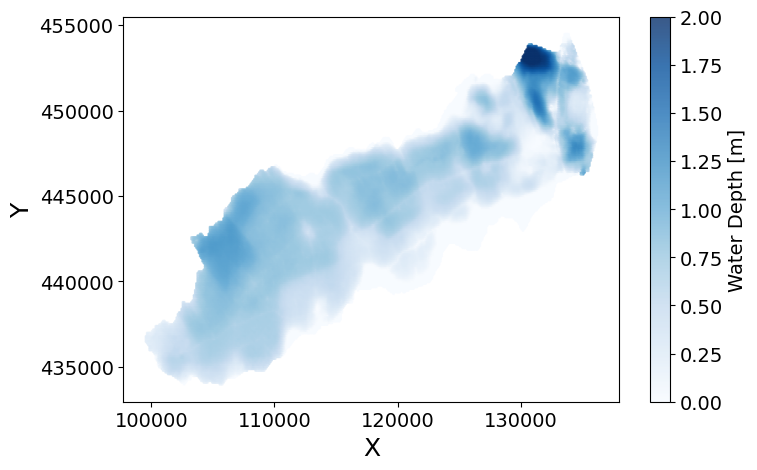

In [5]:
nodes_x_coord, nodes_y_coord, nodes_z_values = scatterplot2D_from_test_dataset(sim_num)

# sim_num_set = cma.np.arange(2001, 2150, 1) # Check simulations

# for i in sim_num_set:
#     print(f'Simulation number: {i}')
#     nodes_x_coord, nodes_y_coord, nodes_z_values = scatterplot2D_from_test_dataset(i)

In [6]:
# Load the data_DF and NPBN_RCM array
NPBN_RCM = cma.np.load('Optimal_Config/NPBN_RCM.npy')
spatial_dict = cma.np.load('Optimal_Config/spatial_dict.npy', allow_pickle=True).item()
data_DF = cma.pd.read_parquet('Optimal_Config/data_DF.parquet')
cluster_DF = cma.pd.read_parquet('Optimal_Config/cluster_DF.parquet')

In [7]:
# cma.RCMPlotting(
#     emp_RCM=None,
#     sat_RCM=None,
#     NPBN_RCM=NPBN_RCM
# ).rcm_single_plot('NPBN')

# Defining measuring stations

In [8]:
selected_clusters = cluster_DF[cluster_DF['clus_idx'].isin(meas_list)] # measuring stations

# Extract arrays of coordinates from spatial_dict
spatial_coords = cma.np.column_stack((spatial_dict['x'], spatial_dict['y']))

# Extract arrays of coordinates from selected_clusters
cluster_coords = cma.np.column_stack((selected_clusters['x'].values, selected_clusters['y'].values))

# Build a KDTree for fast nearest neighbor search
tree = cma.cKDTree(spatial_coords)

# Query the nearest neighbor in spatial_dict for each cluster coordinate
distances, indices = tree.query(cluster_coords)

# Get the closest coordinates and their indices
closest_indices = indices
closest_coords = spatial_coords[indices]

# Save as a list of tuples (index, x, y)
closest_points = [(idx, coord[0], coord[1]) for idx, coord in zip(closest_indices, closest_coords)]

# closest_indices and closest_coords from previous step
df_closest_meas = cma.pd.DataFrame({
    'cluster': selected_clusters['clus_idx'].values,
    'cluster_x': selected_clusters['x'].values,
    'cluster_y': selected_clusters['y'].values,
    'closest_coord': closest_indices,
    'coord_x': closest_coords[:, 0],
    'coord_y': closest_coords[:, 1],
    'coord_val': cma.np.round(nodes_z_values[closest_indices],3)
})

display(df_closest_meas)

,cluster,cluster_x,cluster_y,closest_coord,coord_x,coord_y,coord_val
0,37,109002.878168,442763.847202,22489,108967.785,442770.6795,0.834
1,50,110134.451667,438579.653859,24646,110167.785,438570.6795,0.624
2,109,121829.108155,446878.567541,10685,121867.785,446870.6795,0.765
3,112,122560.000569,443004.212434,12662,122567.785,442970.6795,0.127
4,155,130976.373957,450629.575206,2753,130967.785,450670.6795,1.433
5,158,131774.409606,447034.717355,4426,131767.785,447070.6795,0.248


# Defining locations of interest

In [9]:
selected_clusters = cluster_DF[cluster_DF['clus_idx'].isin(location_list)] # locations of interest

# Extract arrays of coordinates from spatial_dict
spatial_coords = cma.np.column_stack((spatial_dict['x'], spatial_dict['y']))

# Extract arrays of coordinates from selected_clusters
cluster_coords = cma.np.column_stack((selected_clusters['x'].values, selected_clusters['y'].values))

# Build a KDTree for fast nearest neighbor search
tree = cma.cKDTree(spatial_coords)

# Query the nearest neighbor in spatial_dict for each cluster coordinate
distances, indices = tree.query(cluster_coords)

# Get the closest coordinates and their indices
closest_indices = indices
closest_coords = spatial_coords[indices]

# Save as a list of tuples (index, x, y)
closest_points = [(idx, coord[0], coord[1]) for idx, coord in zip(closest_indices, closest_coords)]

# closest_indices and closest_coords from previous step
df_closest_loc = cma.pd.DataFrame({
    'cluster': selected_clusters['clus_idx'].values,
    'cluster_x': selected_clusters['x'].values,
    'cluster_y': selected_clusters['y'].values,
    'closest_coord': closest_indices,
    'coord_x': closest_coords[:, 0],
    'coord_y': closest_coords[:, 1],
    'coord_val': cma.np.round(nodes_z_values[closest_indices],3)
})

display(df_closest_loc)

,cluster,cluster_x,cluster_y,closest_coord,coord_x,coord_y,coord_val
0,70,113977.365838,442494.032793,18993,113967.785,442470.6795,0.684
1,169,134055.241446,449194.372880,1843,134067.785,449170.6795,0.677


# Plotting setup

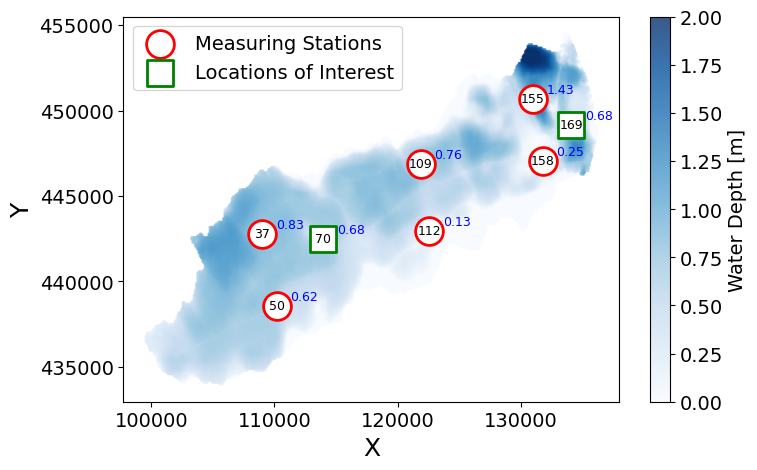

In [10]:
scatterplot2D_from_test_dataset(sim_num, df_closest_meas, df_closest_loc);

# Start Inference

In [11]:
start_time = time.time()

condition_nodes = df_closest_meas['cluster'].values.tolist()
condition_values = df_closest_meas['coord_val'].values.tolist()

F = cma.inference(Nodes = condition_nodes,
            Values = condition_values,
            R=NPBN_RCM,
            DATA=data_DF,
            empirical_data=True, 
            SampleSize=1000,
            Output='full')[0]

### Inference correction factor

When performing inference, `F` will not include the conditioning nodes, therefore a correction factor is necessary.

In [12]:
location_clusters_CorrFac = []

for i in range(len(df_closest_loc['cluster'])):
    count = 0
    for j in range(len(df_closest_meas['cluster'])): 
        if df_closest_loc['cluster'][i] >= df_closest_meas['cluster'][j]:
            count += 1
    location_clusters_CorrFac.append(count)

# Results

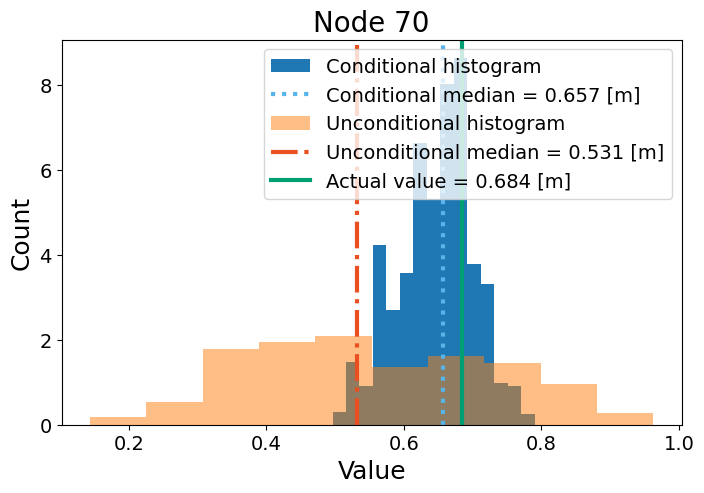

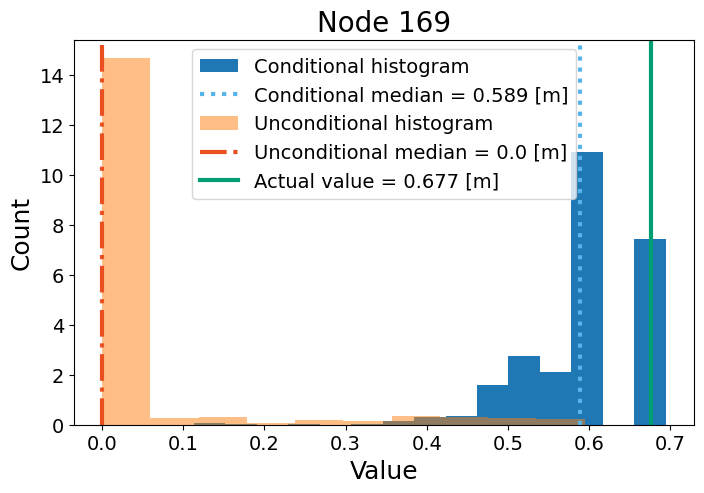

In [13]:
location_clusters = df_closest_loc['cluster'].values

locations = ['best', 'best', 'best']
median_cond_list = [None, None, None]
median_uncond_list = [None, None, None]
ActVal_list = [None, None, None]

for i in range(len(location_clusters)):
    data_cond = F[int(location_clusters[i] - location_clusters_CorrFac[i])]
    data_uncond = data_DF.iloc[:,int(location_clusters[i])]

    cma.plt.figure(figsize=(8, 5))

    cma.plt.hist(data_cond, bins=15, density=True, label='Conditional histogram')

    median_cond = cma.np.median(data_cond)
    median_cond_list[i] = cma.np.round(median_cond,3)
    cma.plt.axvline(median_cond,color='#56B4E9', linestyle=':', linewidth=3, label=f'Conditional median = {cma.np.round(median_cond, 3)} [m]')

    cma.plt.hist(data_uncond, bins=10, density=True, label='Unconditional histogram', alpha=0.5)

    median_uncond = cma.np.median(data_uncond)
    median_uncond_list[i] = cma.np.round(median_uncond,3)
    cma.plt.axvline(median_uncond,color="#E94F21", linestyle='-.', linewidth=3, label=f'Unconditional median = {cma.np.round(median_uncond, 3)} [m]')

    actual_value = df_closest_loc['coord_val'][i]
    ActVal_list[i] = cma.np.round(actual_value,3)
    cma.plt.axvline(actual_value, color='#009E73', linestyle='-', linewidth=3, label=f'Actual value = {cma.np.round(actual_value, 3)} [m]')
    
    cma.plt.title(f'Node {int(location_clusters[i])}', fontsize=20)
    cma.plt.xlabel('Value', fontsize=18)
    cma.plt.ylabel('Count', fontsize=18)
    cma.plt.tick_params(axis='both', labelsize=14)
    cma.plt.legend(fontsize=14, loc=locations[i])

end_time = time.time()
total_time = end_time - start_time 

# Saving results

In [14]:
# # Data to summarize
# data = {
#     "ActVal_location1": [ActVal_list[0]],
#     "CondEstVal_location1": [median_cond_list[0]],
#     "UncondEstVal_location1": [median_uncond_list[0]],
#     "ActVal_location2": [ActVal_list[1]],
#     "CondEstVal_location2": [median_cond_list[1]],
#     "UncondEstVal_location2": [median_uncond_list[1]],
#     "ActVal_location3": [ActVal_list[2]],
#     "CondEstVal_location3": [median_cond_list[2]],
#     "UncondEstVal_location3": [median_uncond_list[2]],
#     "Total_Time": [total_time]
# }

# # Create a DataFrame
# df = cma.pd.DataFrame(data)

# display(df)

# # Load the existing workbook or create a new one if it doesn't exist
# try:
#     workbook = cma.openpyxl.load_workbook('Output_TestRuns.xlsx')
# except FileNotFoundError:
#     workbook = cma.openpyxl.Workbook()

# # Determine the sheet to update based on the method
# sheet_name = 'INPUT'  # You can change this to any name you prefer

# # Check if the sheet exists; if not, create it
# if sheet_name not in workbook.sheetnames:
#     sheet = workbook.create_sheet(sheet_name)
# else:
#     sheet = workbook[sheet_name]

# # Find the first empty row in the sheet
# start_row = sheet.max_row + 1 # Sometimes the last row is weirdly found very late, check your Excel

# # Append the DataFrame to the sheet
# for row in df.itertuples(index=False, name=None):
#     sheet.append(row)

# # Save the workbook
# workbook.save('Output_TestRuns.xlsx')
# print("Excel file updated successfully!")